In [52]:
import json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pomegranate as pg

%config InlineBackend.figure_format = 'svg'

num_states = 15
agent_percent = 0.15

model_path = '../tmobile/cluster_assignment/bert-base-uncased_mlm-lemax-merge-num2/sshmm/150/models/sshmm_015.json'
msa_path = f'../tmobile/agent_info/msa_{agent_percent}.csv'
lsa_path = f'../tmobile/agent_info/lsa_{agent_percent}.csv'
state_seq_dir = '../tmobile/cluster_assignment/bert-base-uncased_mlm-lemax-merge-num2/state_sequence/150'

with open(model_path, 'r') as f:
    model = pg.HiddenMarkovModel.from_json(json.load(f))
    
idx2state = {}
for i, s in enumerate(model.states):
    idx2state[i] = s.name.split('<-')[0].strip()
    
print(f'# states = {len(idx2state)-2}')

# states = 15


In [53]:
split = 'dev'
msa = pd.read_csv(msa_path, sep='|')
lsa = pd.read_csv(lsa_path, sep='|')

df_path = f'{state_seq_dir}/agent_{split}.csv'
df = pd.read_csv(df_path, sep='|')
m = msa.sourcemediaid.tolist()
l = lsa.sourcemediaid.tolist()
mdf = df[df.example_id.isin(m)].rename(columns={'example_id': 'sourcemediaid'})
ldf = df[df.example_id.isin(l)].rename(columns={'example_id': 'sourcemediaid'})
mdf = mdf.merge(msa[['sourcemediaid', 'agent_type']], on='sourcemediaid')
ldf = ldf.merge(lsa[['sourcemediaid', 'agent_type']], on='sourcemediaid')
mdf['call_length'] = mdf.state_sequence.apply(lambda x: len(x.strip().split(',')))
ldf['call_length'] = ldf.state_sequence.apply(lambda x: len(x.strip().split(',')))        



/g/tial/transitory/roylu/miniconda3/envs/conv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [54]:
print('msa stats')
print(mdf.call_length.describe())
print('lsa stats')
print(ldf.call_length.describe())
min_seq_len = min(mdf.call_length.quantile(0.1), ldf.call_length.quantile(0.1))
max_seq_len = max(mdf.call_length.quantile(0.9), ldf.call_length.quantile(0.9))

join_df = pd.concat([mdf, ldf])
join_df = join_df[(join_df.call_length >= min_seq_len) & (join_df.call_length <= max_seq_len)]
print(join_df.agent_type.value_counts())

msa stats
count    4577.000000
mean       30.247761
std        12.074715
min        13.000000
25%        20.000000
50%        28.000000
75%        38.000000
max        60.000000
Name: call_length, dtype: float64
lsa stats
count    8302.000000
mean       29.576367
std        12.005154
min        13.000000
25%        20.000000
50%        27.000000
75%        38.000000
max        60.000000
Name: call_length, dtype: float64
lsa_ncb    5608
msa_ncb    3749
lsa_cb     1215
msa_cb       58
Name: agent_type, dtype: int64


In [55]:
from collections import Counter, defaultdict

def r(df):
    ret = {}
    ocnt = Counter()
    for k in ['msa_cb', 'msa_ncb', 'lsa_cb', 'lsa_ncb']:
        ret[k] = defaultdict(list)
        
    for s, a in df[['state_sequence', 'agent_type']].itertuples(index=False):
        s = list(map(int, s.split(',')))
        total = len(s)
        cnt = Counter(s)
        ocnt += cnt
        for state_idx, c in cnt.items():
            ret[a][state_idx].append(c/total)

    for agent_type, state_idx2ratios in ret.items():
        for state_idx, ratios in list(state_idx2ratios.items()):
            state = idx2state[state_idx]
            ret[agent_type][state] = sum(ratios) / len(ratios)
            del ret[agent_type][state_idx]
            
    print(ocnt)
        
    return ret

In [56]:
dic = r(join_df)

lst = []
for agent_type, state2ratio in dic.items():
    for state, ratio in state2ratio.items():
        lst.append((agent_type, state, ratio))

df3 = pd.DataFrame(lst, columns=['agent_type', 'state', 'ratio'])

Counter({4: 79034, 6: 61929, 2: 29976, 9: 26589, 11: 23962, 10: 22104, 0: 21027, 1: 15077, 5: 14098, 3: 13414})


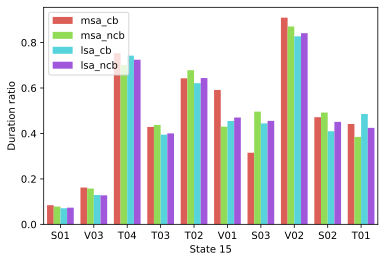

In [57]:
g = sns.barplot(
    x='state',
    y='ratio',
    hue='agent_type',
    data=df3,
    palette = 'hls',  
    capsize = 0.05,             
    saturation = 8,             
    errcolor = 'gray',
    errwidth = 2,  
    ci = 'sd'
)
g.set(xlabel=f'State {num_states}', ylabel='Duration ratio')
plt.legend(loc='upper left')